In [3]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [75]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
import scipy.stats as stats


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

%matplotlib inline

In [76]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [77]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
#NEW_FEATURE_NAMES = ['']
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [78]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


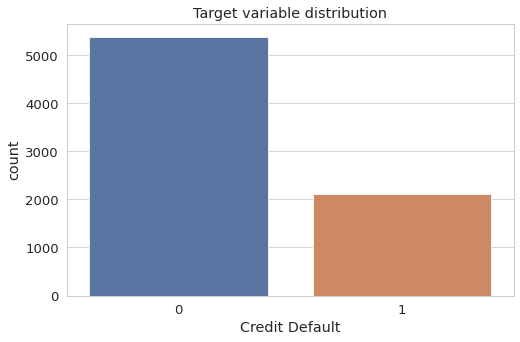

In [79]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [80]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.00",NaN,0.00,11.00,26.30,"685,960.00",1.00,NaN,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,NaN,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,NaN,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,NaN,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,NaN,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0
5,Rent,NaN,7 years,0.00,12.00,14.60,"366,784.00",0.00,NaN,0.00,other,Long Term,"337,304.00","165,680.00","18,692.00",NaN,1
6,Home Mortgage,"1,511,108.00",10+ years,0.00,9.00,20.30,"388,124.00",0.00,73.00,0.00,home improvements,Short Term,"99,999,999.00","51,623.00","2,317.00",745.00,0
7,Rent,"1,040,060.00",10+ years,0.00,13.00,12.00,"330,374.00",0.00,18.00,0.00,other,Short Term,"250,888.00","89,015.00","19,761.00",705.00,1
8,Home Mortgage,NaN,5 years,0.00,17.00,15.70,0.00,1.00,NaN,1.00,home improvements,Short Term,"129,734.00",19.00,17.00,NaN,0
9,Home Mortgage,NaN,1 year,0.00,10.00,24.60,"511,302.00",0.00,6.00,0.00,debt consolidation,Long Term,"572,880.00","205,333.00","17,613.00",NaN,1


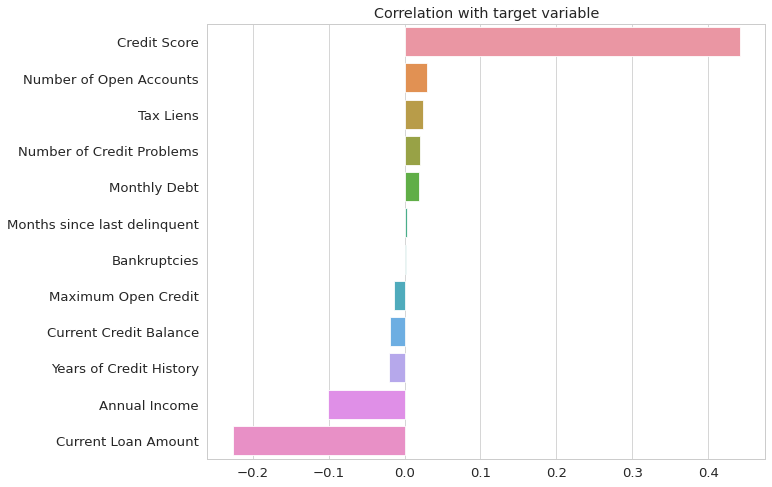

In [81]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

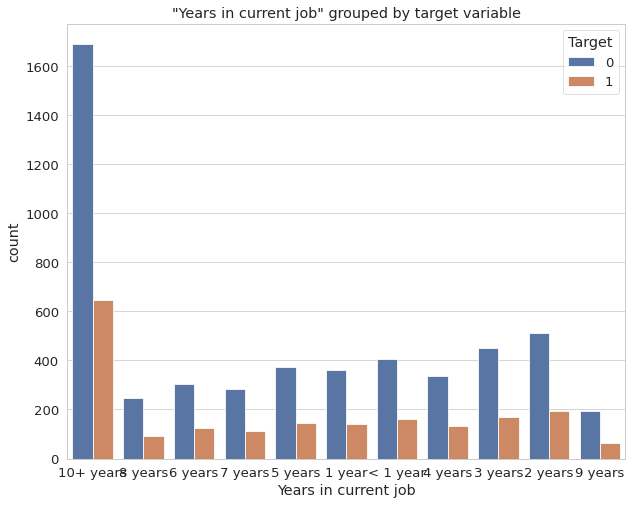

In [83]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [84]:
# пропуски
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [85]:
# Добавляется новый бинарный признак - 1/0 (задолженость/отсутствие задолженности)
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0

# Заменяется пропуск NaN на 0 в 'Months since last delinquent'
df_train['Months since last delinquent'].fillna(0, inplace=True)

In [86]:
# Добавляется новый бинарный признак о неизвестном доходе 1/0 (доход известен/доход не известен)
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1

# В новую переменную annual_income_median записывается медианное значение дохода
annual_income_median = df_train['Annual Income'].median()

# Пропуски дохода заполняются медианным значением
df_train['Annual Income'].fillna(annual_income_median, inplace=True)

In [87]:
df_train.isnull().sum()
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income
0,Own Home,"482,087.00",NaN,0.00,11.00,26.30,"685,960.00",1.00,0.00,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0,1,0
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,0.00,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1,1,0
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,0.00,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0,1,0
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,0.00,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0,1,0
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,0.00,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0,1,0
5,Rent,"1,168,386.00",7 years,0.00,12.00,14.60,"366,784.00",0.00,0.00,0.00,other,Long Term,"337,304.00","165,680.00","18,692.00",NaN,1,1,1
6,Home Mortgage,"1,511,108.00",10+ years,0.00,9.00,20.30,"388,124.00",0.00,73.00,0.00,home improvements,Short Term,"99,999,999.00","51,623.00","2,317.00",745.00,0,1,0
7,Rent,"1,040,060.00",10+ years,0.00,13.00,12.00,"330,374.00",0.00,18.00,0.00,other,Short Term,"250,888.00","89,015.00","19,761.00",705.00,1,1,0
8,Home Mortgage,"1,168,386.00",5 years,0.00,17.00,15.70,0.00,1.00,0.00,1.00,home improvements,Short Term,"129,734.00",19.00,17.00,NaN,0,1,1
9,Home Mortgage,"1,168,386.00",1 year,0.00,10.00,24.60,"511,302.00",0.00,6.00,0.00,debt consolidation,Long Term,"572,880.00","205,333.00","17,613.00",NaN,1,1,1


In [88]:
NEW_FEATURE_NAMES = ['has_delay','unknown_income']

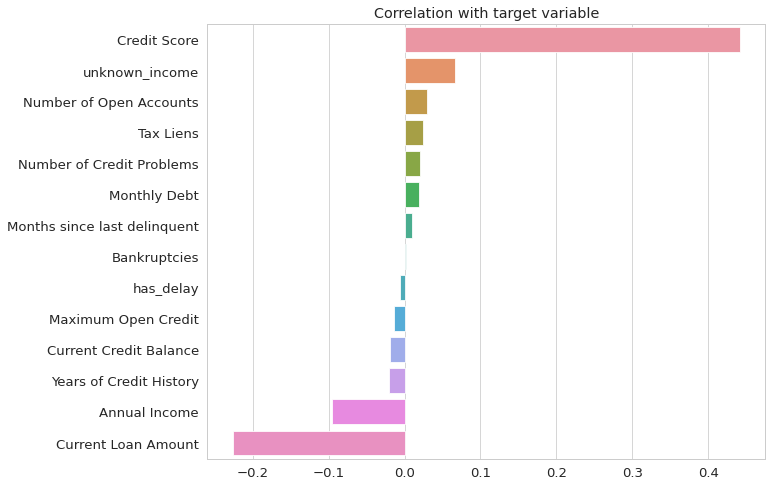

In [89]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

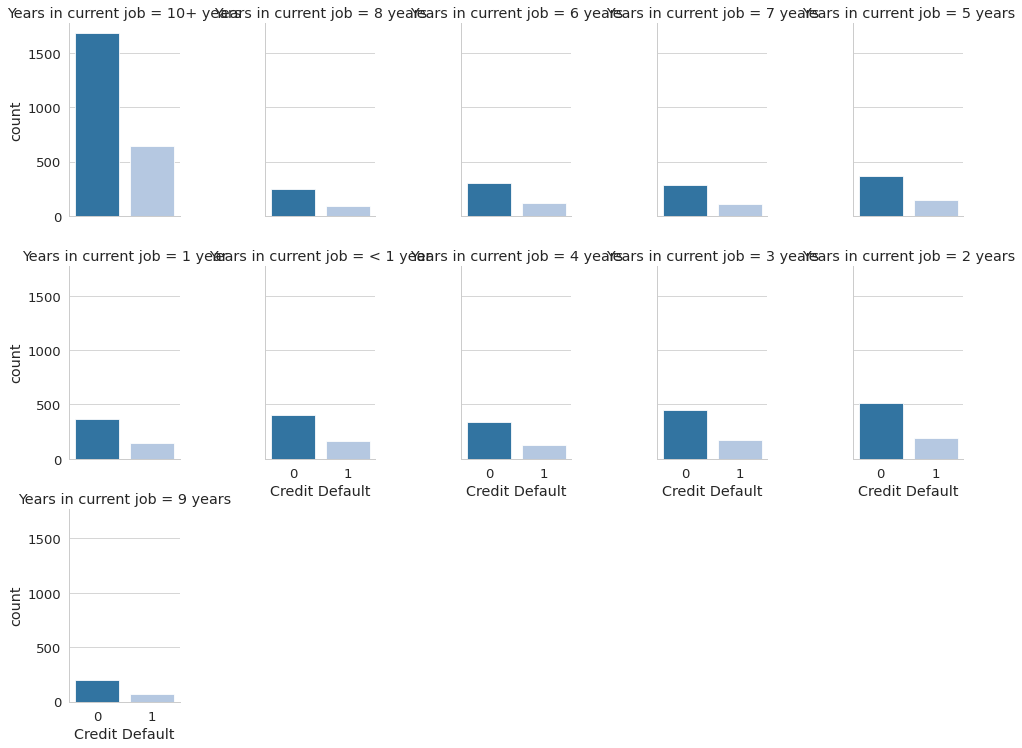

In [90]:
# Определение количества людей, в группах по стажу работы, не возвращающих кредит

g = sns.catplot("Credit Default", col="Years in current job", col_wrap=5,
                data=df_train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

#fig.suptitle('sf')
plt.show()

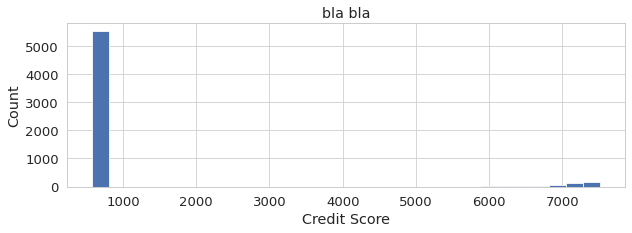

In [91]:
plt.figure(figsize = (10, 3))

df_train['Credit Score'].hist(bins=30, )
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('bla bla')
plt.show()

In [92]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
has_delay                          0
unknown_income                     0
dtype: int64

In [93]:
# Добавляется новая переменная unknown_credit_score по неизвестному Credit Score с присвоением 0 всем наблюдениям 
df_train['unknown_credit_score'] = 0

NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

# В переменную credit_score_median записывается медианное значение рейтинга
credit_score_median = df_train['Credit Score'].median()

# По известному кредитному рейтингу присваивается 1 в переменной unknown_credit_score
df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1

# Пропуски рейтинга заполняются медианным значением
df_train['Credit Score'].fillna(credit_score_median, inplace=True)

In [94]:
import random

# Уникальные значения Years in current job
unique_years_in_current_job = df_train['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

# NaN заменяется на рандомный опыт
df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [95]:
df_train.isnull().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
has_delay                        0
unknown_income                   0
unknown_credit_score             0
dtype: int64

In [96]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score
0,Own Home,"482,087.00",1 year,0.00,11.00,26.30,"685,960.00",1.00,0.00,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0,1,0,0
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,0.00,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1,1,0,0
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,0.00,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0,1,0,0
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,0.00,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0,1,0,0
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,0.00,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0,1,0,0
5,Rent,"1,168,386.00",7 years,0.00,12.00,14.60,"366,784.00",0.00,0.00,0.00,other,Long Term,"337,304.00","165,680.00","18,692.00",731.00,1,1,1,1
6,Home Mortgage,"1,511,108.00",10+ years,0.00,9.00,20.30,"388,124.00",0.00,73.00,0.00,home improvements,Short Term,"99,999,999.00","51,623.00","2,317.00",745.00,0,1,0,0
7,Rent,"1,040,060.00",10+ years,0.00,13.00,12.00,"330,374.00",0.00,18.00,0.00,other,Short Term,"250,888.00","89,015.00","19,761.00",705.00,1,1,0,0
8,Home Mortgage,"1,168,386.00",5 years,0.00,17.00,15.70,0.00,1.00,0.00,1.00,home improvements,Short Term,"129,734.00",19.00,17.00,731.00,0,1,1,1
9,Home Mortgage,"1,168,386.00",1 year,0.00,10.00,24.60,"511,302.00",0.00,6.00,0.00,debt consolidation,Long Term,"572,880.00","205,333.00","17,613.00",731.00,1,1,1,1


In [97]:
# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [98]:
df_train.Bankruptcies.value_counts()

0.00    6660
1.00     786
2.00      31
3.00       7
4.00       2
Name: Bankruptcies, dtype: int64

In [99]:
df_train['Bankruptcies'].fillna(0 , inplace=True)

In [100]:
df_train.Bankruptcies.value_counts()

0.00    6674
1.00     786
2.00      31
3.00       7
4.00       2
Name: Bankruptcies, dtype: int64

In [101]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
has_delay                       0
unknown_income                  0
unknown_credit_score            0
dtype: int64

In [102]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
1 year        875
2 years       705
3 years       620
< 1 year      563
5 years       516
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [103]:
df_train['term_binary'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score','term_binary']

In [104]:
df_train.select_dtypes(include='object').columns[1:]

Index(['Years in current job', 'Purpose', 'Term'], dtype='object')

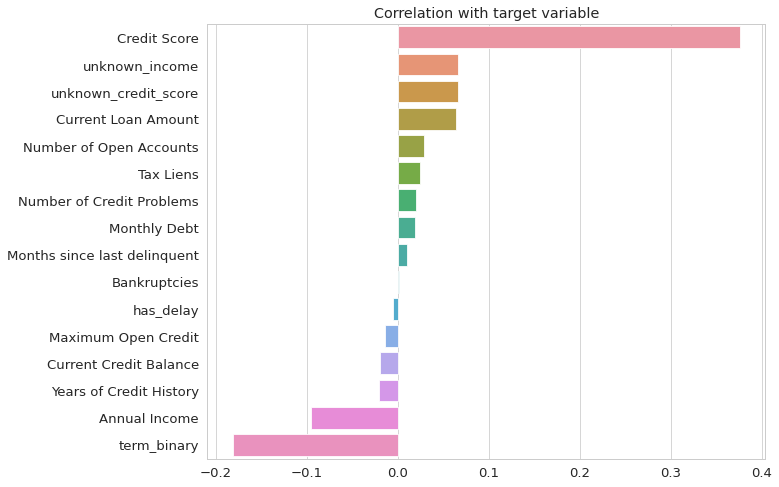

In [105]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [126]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [107]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [108]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score,term_binary
0,Own Home,"482,087.00",1 year,0.00,11.00,26.30,"685,960.00",1.00,0.00,1.00,...,Short Term,"309,573.00","47,386.00","7,914.00",749.00,0,1,0,0,1
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,0.00,0.00,...,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1,1,0,0,0
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,0.00,0.00,...,Short Term,"309,573.00","308,389.00","13,651.00",742.00,0,1,0,0,1
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,0.00,1.00,...,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0,1,0,0,1
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,0.00,0.00,...,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0,1,0,0,1
5,Rent,"1,168,386.00",7 years,0.00,12.00,14.60,"366,784.00",0.00,0.00,0.00,...,Long Term,"337,304.00","165,680.00","18,692.00",731.00,1,1,1,1,0
6,Home Mortgage,"1,511,108.00",10+ years,0.00,9.00,20.30,"388,124.00",0.00,73.00,0.00,...,Short Term,"309,573.00","51,623.00","2,317.00",745.00,0,1,0,0,1
7,Rent,"1,040,060.00",10+ years,0.00,13.00,12.00,"330,374.00",0.00,18.00,0.00,...,Short Term,"250,888.00","89,015.00","19,761.00",705.00,1,1,0,0,1
8,Home Mortgage,"1,168,386.00",5 years,0.00,17.00,15.70,0.00,1.00,0.00,1.00,...,Short Term,"129,734.00",19.00,17.00,731.00,0,1,1,1,1
9,Home Mortgage,"1,168,386.00",1 year,0.00,10.00,24.60,"511,302.00",0.00,6.00,0.00,...,Long Term,"572,880.00","205,333.00","17,613.00",731.00,1,1,1,1,0


In [109]:
NEW_FEATURE_NAMES

['has_delay', 'unknown_income', 'unknown_credit_score', 'term_binary']

In [110]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES


X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

In [111]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

In [112]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

In [113]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [121]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3768
           1       0.63      0.42      0.51      2964

    accuracy                           0.64      6732
   macro avg       0.64      0.61      0.61      6732
weighted avg       0.64      0.64      0.62      6732

TEST

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1619
           1       0.47      0.41      0.44       631

    accuracy                           0.71      2250
   macro avg       0.63      0.62      0.62      2250
weighted avg       0.69      0.71      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  291
1                372  259


In [115]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3768
           1       0.74      0.67      0.70      2964

    accuracy                           0.75      6732
   macro avg       0.75      0.74      0.74      6732
weighted avg       0.75      0.75      0.75      6732

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1619
           1       0.35      0.39      0.37       631

    accuracy                           0.62      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.64      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1157  462
1                386  245


In [116]:
model_xgb = xgb.XGBClassifier(random_state=11)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      3768
           1       0.79      0.56      0.65      2964

    accuracy                           0.74      6732
   macro avg       0.75      0.72      0.72      6732
weighted avg       0.75      0.74      0.73      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1619
           1       0.56      0.46      0.50       631

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1389  230
1                341  290


In [117]:
model_lgbm = lgbm.LGBMClassifier(random_state=11)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3768
           1       0.94      0.88      0.91      2964

    accuracy                           0.92      6732
   macro avg       0.93      0.92      0.92      6732
weighted avg       0.92      0.92      0.92      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1619
           1       0.53      0.46      0.49       631

    accuracy                           0.73      2250
   macro avg       0.66      0.65      0.66      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1364  255
1                343  288


In [118]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3768
           1       0.92      0.84      0.88      2964

    accuracy                           0.90      6732
   macro avg       0.90      0.89      0.90      6732
weighted avg       0.90      0.90      0.90      6732

TEST

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1619
           1       0.54      0.43      0.48       631

    accuracy                           0.74      2250
   macro avg       0.67      0.64      0.65      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1388  231
1                360  271


In [58]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

In [59]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [60]:
cv=KFold(n_splits=3, random_state=11, shuffle=True)

In [61]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 1.09 s, sys: 185 ms, total: 1.28 s
Wall time: 1min 15s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7ff4bc829950>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [62]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 5}

In [63]:
rs.best_score_

0.5366371023559551

In [67]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3768
           1       0.80      0.63      0.70      2964

    accuracy                           0.77      6732
   macro avg       0.77      0.75      0.76      6732
weighted avg       0.77      0.77      0.76      6732

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1619
           1       0.54      0.48      0.51       631

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1363  256
1                330  301
CPU times: user 5.79 s, sys: 726 ms, total: 6.52 s
Wall time: 3.62 s


In [68]:
# Добавляется признак has_delay, всем наблюдениям присваивается 1
df_test['has_delay'] = 1

# Заменяется NaN на 0 в 'Months since last delinquent'
df_test['Months since last delinquent'].fillna(0, inplace=True)

# По отсутствующей задолженности присваивается 0 в has_delay
df_test.loc[(df_test['Months since last delinquent'] == 0), 'has_delay'] = 0

# Добавляется признак unknown_income, всем наблюдениям присваивается 0
df_test['unknown_income'] = 0

# В annual_income_median записываеся медианное значение дохода
annual_income_median = df_test['Annual Income'].median()

# В unknown_income по неизвестному доходу присваивается 1 
df_test.loc[(df_test['Annual Income'].isnull()), 'unknown_income'] = 1

# Пропуски дохода заполняются медианными значениями
df_test['Annual Income'].fillna(annual_income_median, inplace=True)

# Добавляется признак unknown_credit_score, всем наблюдениям присваивается 0
df_test['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

# В credit_score_median записываю медианное значение рейтинга
credit_score_median = df_test['Credit Score'].median()

# В unknown_credit_score по неизвестному рейтингу присваивается 1 
df_test.loc[(df_test['Credit Score'].isnull()), 'unknown_credit_score'] = 1

# Пропуски рейтинга заменяются медианными значениями
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

# Уникальные значения поля Years in current job
unique_years_in_current_job = df_test['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

# NaN заменяются рандомными значениями трудового стажа
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

df_test['term_binary'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [69]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(10)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,has_delay,unknown_income,unknown_credit_score,term_binary
0,"1,178,475.00",0.00,9.00,12.50,"220,968.00",0.00,70.00,0.00,"162,470.00","105,906.00","6,813.00",731.00,1,1,1,1
1,"231,838.00",0.00,6.00,32.70,"55,946.00",0.00,8.00,0.00,"78,298.00","46,037.00","2,318.00",699.00,1,0,0,1
2,"1,152,540.00",0.00,10.00,13.70,"204,600.00",0.00,0.00,0.00,"200,178.00","146,490.00","18,729.00","7,260.00",0,0,0,1
3,"1,220,313.00",0.00,16.00,17.00,"456,302.00",0.00,70.00,0.00,"217,382.00","213,199.00","27,559.00",739.00,1,0,0,1
4,"2,340,952.00",0.00,11.00,23.60,"1,207,272.00",0.00,0.00,0.00,"777,634.00","425,391.00","42,605.00",706.00,0,0,0,0
5,"922,583.00",0.00,26.00,17.50,"713,174.00",0.00,41.00,0.00,"94,028.00","135,508.00","11,148.00",679.00,1,0,0,1
6,"1,233,309.00",0.00,7.00,22.00,"376,420.00",0.00,43.00,0.00,"454,388.00","292,904.00","8,181.00",685.00,1,0,0,1
7,"1,215,867.00",0.00,13.00,12.20,"195,888.00",0.00,19.00,0.00,"407,726.00","120,099.00","7,599.00",701.00,1,0,0,1
8,"1,178,475.00",0.00,8.00,9.10,"370,524.00",0.00,0.00,0.00,"131,956.00","237,747.00","10,112.00",731.00,0,1,1,1
9,"2,140,445.00",1.00,15.00,16.70,"867,680.00",1.00,9.00,0.00,"391,336.00","294,500.00","18,372.00",745.00,1,0,0,1


In [70]:
y_pred_output = final_model.predict(df_for_model)

In [71]:
y_pred_output.shape

(2500,)

In [72]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [73]:
RESULT_PATH='./LBiryukova_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [74]:
SAMPLE = './LBiryukova_predictions.csv'
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
Id,
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,0
